In [1]:
import jax
import jax.numpy as jnp

/Users/peter/miniconda3/envs/ml_algorithms/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
x = jnp.arange(10)
x

DeviceArray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [3]:
long_vector = jnp.arange(int(1e7))
%timeit jnp.dot(long_vector, long_vector).block_until_ready()

3.2 ms ± 6.46 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

In [6]:
x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

In [7]:
print(sum_of_squares(x))

30.0


In [8]:
sum_of_squares_dx(x)

DeviceArray([2., 4., 6., 8.], dtype=float32)

In [9]:
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)
y = jnp.asarray([1.1, 2.1, 3.1, 4.1])
sum_squared_error_dx(x,y)

DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32)

In [10]:
jax.grad(sum_squared_error, argnums=(0,1))(x,y)

(DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 DeviceArray([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

In [11]:
jax.value_and_grad(sum_squared_error)(x,y)

(DeviceArray(0.03999995, dtype=float32),
 DeviceArray([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32))

In [12]:
sum_squared_error(x,y)

DeviceArray(0.03999995, dtype=float32)

In [13]:
import numpy as np

In [14]:
import matplotlib.pyplot as plt


In [15]:
xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise


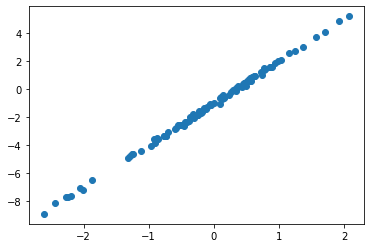

In [16]:
plt.scatter(xs, ys)

In [17]:
def model(theta, x):
    w,b = theta
    return w * x + b

In [18]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction-y) ** 2)

In [19]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

In [20]:
theta = jnp.array([1., 1.])
for _ in range(1000):
    theta = update(theta, xs, ys)
    

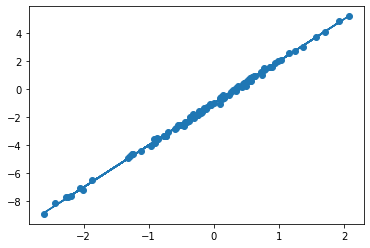

In [21]:
plt.scatter(xs,ys)
plt.plot(xs, model(theta, xs))

In [22]:
w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

w: 3.00, b: -0.99


# JIT

In [23]:
global_list = []
def log2(x):
    global_list.append(x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [25]:
def log2_with_print(x):
    print("printed x:", x)
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2

print(jax.make_jaxpr(log2_with_print)(3.))


printed x: Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


# Auto Vectorization

In [10]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

In [11]:
x, w

(DeviceArray([0, 1, 2, 3, 4], dtype=int32),
 DeviceArray([2., 3., 4.], dtype=float32))

In [12]:
auto_batch_convolve = jax.vmap(convolve)


In [14]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])
xs, ws

(DeviceArray([[0, 1, 2, 3, 4],
              [0, 1, 2, 3, 4]], dtype=int32),
 DeviceArray([[2., 3., 4.],
              [2., 3., 4.]], dtype=float32))

In [15]:
auto_batch_convolve(xs, ws)


DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

# Neural Network

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

/Users/peter/miniconda3/envs/ml_algorithms/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [9]:
params[0][0].shape, params[0][1].shape

((512, 784), (512,))

In [16]:
from jax.scipy.special import logsumexp
def relu(x):
    return jnp.maximum(0, x)

In [17]:
def predict(params, image):
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

In [19]:
# This works on single examples
random_flattened_image = random.normal(random.PRNGKey(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape, preds)

(10,) [-2.2827816 -2.298299  -2.292807  -2.3304513 -2.3079185 -2.3170116
 -2.3065283 -2.296568  -2.300571  -2.2937381]


In [22]:
random_flattened_images = random.normal(random.PRNGKey(1), (10, 28 * 28))


In [23]:
batched_predict = vmap(predict, in_axes=(None, 0))

In [24]:
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


In [25]:
def loss(params, images, targets):
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

In [26]:
@jit
def update(params, x, y):
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db) for (w, b), (dw, db) in zip(params, grads)]

In [28]:
!pip install torch torchvision


     |████████████████████████████████| 43.1 MB 34.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 159.3 MB/s eta 0:00:01
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached urllib3-1.26.8-py2.py3-none-any.whl (138 kB)


In [29]:
import numpy as np
from torch.utils import data
from torchvision.datasets import MNIST

def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

In [30]:
# Define our dataset, using torch datasets
mnist_dataset = MNIST('/tmp/mnist/', download=True, transform=FlattenAndCast())
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [33]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

In [34]:
# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('/tmp/mnist/', download=True, train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/Users/peter/miniconda3/envs/ml_algorithms/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/peter/miniconda3/envs/ml_algorithms/lib/python3.9/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/peter/miniconda3/envs/ml_algorithms/lib/python3.9/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [38]:
import time

for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in training_generator:
        y = one_hot(y, n_targets)
        params = update(params, x, y)
    epoch_time = time.time() - start_time
    
    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

Epoch 0 in 2.48 sec
Training set accuracy 0.9157166481018066
Test set accuracy 0.9195999503135681
Epoch 1 in 2.21 sec
Training set accuracy 0.937166690826416
Test set accuracy 0.9382999539375305
Epoch 2 in 2.20 sec
Training set accuracy 0.949150025844574
Test set accuracy 0.9467999935150146
Epoch 3 in 2.24 sec
Training set accuracy 0.9568833708763123
Test set accuracy 0.9535999894142151
Epoch 4 in 2.23 sec
Training set accuracy 0.9630166888237
Test set accuracy 0.9573999643325806
Epoch 5 in 2.24 sec
Training set accuracy 0.9674500226974487
Test set accuracy 0.9615999460220337
Epoch 6 in 2.23 sec
Training set accuracy 0.9708666801452637
Test set accuracy 0.9652999639511108
Epoch 7 in 2.23 sec
Training set accuracy 0.9738166928291321
Test set accuracy 0.9672999978065491
